# Exercise 7: LoRA (Low-Rank Adaptation) Implementation

This notebook implements LoRA (Low-Rank Adaptation) on the encoder neural network from Exercise 5. LoRA is a parameter-efficient fine-tuning technique that freezes the original model weights and introduces trainable low-rank matrices to adapt the model to new tasks.

## Key Components:
1. **LoRAModel**: A modified version of the autoencoder from E5 with LoRA adaptation
2. **Low-rank matrices**: lora_A and lora_B matrices for efficient parameter updates
3. **Frozen weights**: Original model weights are frozen, only LoRA parameters are trained
4. **Efficient training**: Significantly fewer parameters to train compared to full fine-tuning

In [ ]:
# Import necessary libraries for PyTorch deep learning and LoRA implementation
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Tuple, Any
import math

In [2]:
# Set up the device for training (GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Download and prepare the Fashion MNIST dataset
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Create data loaders
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Using cuda device


In [3]:
# Original Autoencoder class from Exercise 5 (for reference and loading pretrained weights)
class Autoencoder(nn.Module):
    def __init__(self):
        """
        Initialize the autoencoder with encoder and decoder layers.
        """
        super().__init__()
        
        # Encoder component
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),  # lin_1: First hidden layer
            nn.ReLU(),
            nn.Linear(512, 128),      # lin_2: Second hidden layer
            nn.ReLU(),
        )
        
        # Classification head
        self.classifier = nn.Linear(128, 10)
        
        # Decoder component
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        return x
        
    def forward(self, x):
        original_shape = x.shape
        latent = self.encode(x)
        class_logits = self.classifier(latent)
        reconstructed = self.decoder(latent)
        reconstructed = reconstructed.view(original_shape)
        return class_logits, reconstructed

In [4]:
# LoRAModel - Modified version of Autoencoder with LoRA adaptation
class LoRAModel(nn.Module):
    def __init__(self, rank=64, lora_alpha=1.0):
        """
        Initialize the LoRA model based on the Autoencoder architecture.
        
        Args:
            rank: The rank of the LoRA matrices (intermediate dimension)
            lora_alpha: Scaling factor for LoRA updates
        """
        super().__init__()
        
        self.rank = rank
        self.lora_alpha = lora_alpha
        self.scaling = lora_alpha / rank
        
        # Encoder component (same as original)
        self.flatten = nn.Flatten()
        
        # First linear layer (lin_1) - will be frozen
        self.lin_1 = nn.Linear(28 * 28, 512)
        self.relu1 = nn.ReLU()
        
        # Second linear layer (lin_2) - will be frozen, but adapted with LoRA
        self.lin_2 = nn.Linear(512, 128)
        self.relu2 = nn.ReLU()
        
        # Classification head
        self.classifier = nn.Linear(128, 10)
        
        # Decoder component
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
        )
        
        # LoRA matrices for lin_2 (512 -> 128)
        # lora_A: (rank, in_features) - maps input to low-rank space
        # lora_B: (out_features, rank) - maps from low-rank space to output
        self.lora_A = nn.Parameter(torch.zeros(rank, 512))
        self.lora_B = nn.Parameter(torch.zeros(128, rank))
        
        # Initialize LoRA matrices
        self.reset_lora_parameters()
        
    def reset_lora_parameters(self):
        """Initialize LoRA parameters according to the paper"""
        # Initialize lora_A with Kaiming uniform distribution
        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        # Initialize lora_B with zeros
        nn.init.zeros_(self.lora_B)
        
    def freeze_original_weights(self):
        """Freeze the original model weights (lin_1 and lin_2)"""
        self.lin_1.requires_grad_(False)
        self.lin_2.requires_grad_(False)
        print("Frozen original weights: lin_1 and lin_2")
        
    def encode(self, x):
        """Encode input with LoRA adaptation"""
        x = self.flatten(x)
        
        # First layer (frozen)
        x = self.lin_1(x)
        x = self.relu1(x)
        
        # Second layer with LoRA adaptation
        # Original forward: x @ W.T + b
        # LoRA forward: x @ W.T + x @ A.T @ B.T * scaling + b
        original_output = self.lin_2(x)
        lora_output = (x @ self.lora_A.T) @ self.lora_B.T * self.scaling
        x = original_output + lora_output
        x = self.relu2(x)
        
        return x
        
    def forward(self, x):
        """Forward pass with LoRA adaptation"""
        original_shape = x.shape
        latent = self.encode(x)
        class_logits = self.classifier(latent)
        reconstructed = self.decoder(latent)
        reconstructed = reconstructed.view(original_shape)
        return class_logits, reconstructed
        
    def count_parameters(self):
        """Count total and trainable parameters"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total_params, trainable_params

In [5]:
# First, let's create and train a base model to get pretrained weights
# (In practice, you would load a pretrained model from Exercise 5)

def train_base_model(epochs=5):
    """Train a base autoencoder model to get pretrained weights"""
    print("Training base model to get pretrained weights...")
    
    # Create base model
    base_model = Autoencoder().to(device)
    
    # Loss functions and optimizer
    class_loss_fn = nn.CrossEntropyLoss()
    recon_loss_fn = nn.MSELoss()
    recon_weight = 0.5
    optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-3)
    
    # Training function
    def train_epoch(dataloader, model, class_loss_fn, recon_loss_fn, recon_weight, optimizer):
        model.train()
        total_loss = 0
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            class_pred, reconstructed = model(X)
            class_loss = class_loss_fn(class_pred, y)
            recon_loss = recon_loss_fn(reconstructed, X)
            loss = class_loss + recon_weight * recon_loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch % 200 == 0:
                print(f"  Batch {batch}, Loss: {loss.item():.4f}")
                
        return total_loss / len(dataloader)
    
    # Train for specified epochs
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        avg_loss = train_epoch(train_dataloader, base_model, class_loss_fn, recon_loss_fn, recon_weight, optimizer)
        print(f"  Average Loss: {avg_loss:.4f}")
        
    return base_model

# Check if we have a pretrained model, otherwise train one
import os
pretrained_path = "base_model.pth"

if os.path.exists(pretrained_path):
    print(f"Loading pretrained model from {pretrained_path}")
    base_model = Autoencoder().to(device)
    base_model.load_state_dict(torch.load(pretrained_path, weights_only=True))
else:
    print("No pretrained model found. Training base model...")
    base_model = train_base_model(epochs=3)  # Train for fewer epochs for demo
    torch.save(base_model.state_dict(), pretrained_path)
    print(f"Saved base model to {pretrained_path}")

print("Base model ready!")

No pretrained model found. Training base model...
Training base model to get pretrained weights...
Epoch 1/3
  Batch 0, Loss: 2.3996
  Batch 200, Loss: 0.5586
  Batch 400, Loss: 0.3475
  Batch 600, Loss: 0.4397
  Batch 800, Loss: 0.2967
  Average Loss: 0.5205
Epoch 2/3
  Batch 0, Loss: 0.3682
  Batch 200, Loss: 0.3917
  Batch 400, Loss: 0.5409
  Batch 600, Loss: 0.4053
  Batch 800, Loss: 0.3232
  Average Loss: 0.3706
Epoch 3/3
  Batch 0, Loss: 0.4232
  Batch 200, Loss: 0.4290
  Batch 400, Loss: 0.2543
  Batch 600, Loss: 0.2069
  Batch 800, Loss: 0.2397
  Average Loss: 0.3348
Saved base model to base_model.pth
Base model ready!


In [6]:
# Initialize LoRA model and load pretrained weights
print("="*50)
print("INITIALIZING LORA MODEL")
print("="*50)

# Create LoRA model
lora_model = LoRAModel(rank=64, lora_alpha=1.0).to(device)

# Load weights from pretrained base model
# We need to carefully map the weights since the architecture is slightly different
pretrained_dict = base_model.state_dict()

# Create a mapping for the weights
lora_dict = lora_model.state_dict()

# Map the weights (skip LoRA parameters as they are already initialized)
for key in pretrained_dict:
    if key in lora_dict and 'lora' not in key:
        # Map encoder weights
        if key == 'encoder.0.weight':
            lora_dict['lin_1.weight'] = pretrained_dict[key]
        elif key == 'encoder.0.bias':
            lora_dict['lin_1.bias'] = pretrained_dict[key]
        elif key == 'encoder.2.weight':
            lora_dict['lin_2.weight'] = pretrained_dict[key]
        elif key == 'encoder.2.bias':
            lora_dict['lin_2.bias'] = pretrained_dict[key]
        else:
            # For other layers (classifier, decoder), copy directly
            lora_dict[key] = pretrained_dict[key]

# Load the modified state dict
lora_model.load_state_dict(lora_dict)

# Now freeze the original weights
lora_model.freeze_original_weights()

print("LoRA model initialized with pretrained weights!")

INITIALIZING LORA MODEL
Frozen original weights: lin_1 and lin_2
LoRA model initialized with pretrained weights!


In [7]:
# Print trainable parameters comparison
print("="*50)
print("PARAMETER COMPARISON")
print("="*50)

# Count parameters in base model
base_total = sum(p.numel() for p in base_model.parameters())
base_trainable = sum(p.numel() for p in base_model.parameters() if p.requires_grad)

# Count parameters in LoRA model
lora_total, lora_trainable = lora_model.count_parameters()

print(f"Base Model:")
print(f"  Total parameters: {base_total:,}")
print(f"  Trainable parameters: {base_trainable:,}")

print(f"\nLoRA Model:")
print(f"  Total parameters: {lora_total:,}")
print(f"  Trainable parameters: {lora_trainable:,}")

print(f"\nParameter Efficiency:")
print(f"  LoRA trainable vs Base trainable: {lora_trainable/base_trainable:.2%}")
print(f"  LoRA trainable vs LoRA total: {lora_trainable/lora_total:.2%}")

# Print details of trainable parameters
print(f"\nTrainable Parameters in LoRA Model:")
for name, param in lora_model.named_parameters():
    if param.requires_grad:
        print(f"  {name}: {param.shape} ({param.numel():,})")
        
print(f"\nLoRA Matrix Details:")
print(f"  lora_A shape: {lora_model.lora_A.shape} (rank={lora_model.rank}, in_features=512)")
print(f"  lora_B shape: {lora_model.lora_B.shape} (out_features=128, rank={lora_model.rank})")
print(f"  Total LoRA parameters: {lora_model.lora_A.numel() + lora_model.lora_B.numel():,}")

PARAMETER COMPARISON
Base Model:
  Total parameters: 937,114
  Trainable parameters: 937,114

LoRA Model:
  Total parameters: 978,074
  Trainable parameters: 510,490

Parameter Efficiency:
  LoRA trainable vs Base trainable: 54.47%
  LoRA trainable vs LoRA total: 52.19%

Trainable Parameters in LoRA Model:
  lora_A: torch.Size([64, 512]) (32,768)
  lora_B: torch.Size([128, 64]) (8,192)
  classifier.weight: torch.Size([10, 128]) (1,280)
  classifier.bias: torch.Size([10]) (10)
  decoder.0.weight: torch.Size([512, 128]) (65,536)
  decoder.0.bias: torch.Size([512]) (512)
  decoder.2.weight: torch.Size([784, 512]) (401,408)
  decoder.2.bias: torch.Size([784]) (784)

LoRA Matrix Details:
  lora_A shape: torch.Size([64, 512]) (rank=64, in_features=512)
  lora_B shape: torch.Size([128, 64]) (out_features=128, rank=64)
  Total LoRA parameters: 40,960


In [8]:
# Training and evaluation functions for LoRA model
def train_lora(dataloader, model, class_loss_fn, recon_loss_fn, recon_weight, optimizer):
    """Train the LoRA model for one epoch"""
    size = len(dataloader.dataset)
    model.train()
    
    total_loss = 0
    correct = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        class_pred, reconstructed = model(X)
        
        # Calculate losses
        class_loss = class_loss_fn(class_pred, y)
        recon_loss = recon_loss_fn(reconstructed, X)
        loss = class_loss + recon_weight * recon_loss
        
        # Backpropagation (only LoRA parameters will be updated)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        correct += (class_pred.argmax(1) == y).type(torch.float).sum().item()
        
        if batch % 200 == 0:
            current = (batch + 1) * len(X)
            print(f"  Batch {batch:>3d}: loss: {loss.item():>7f}, acc: {correct/(batch+1)/len(X):.3f} [{current:>5d}/{size:>5d}]")
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / size
    return avg_loss, accuracy

def test_lora(dataloader, model, class_loss_fn, recon_loss_fn, recon_weight):
    """Evaluate the LoRA model"""
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    
    test_loss = 0
    class_loss_total = 0
    recon_loss_total = 0
    correct = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            class_pred, reconstructed = model(X)
            
            class_loss = class_loss_fn(class_pred, y).item()
            recon_loss = recon_loss_fn(reconstructed, X).item()
            total_loss = class_loss + recon_weight * recon_loss
            
            test_loss += total_loss
            class_loss_total += class_loss
            recon_loss_total += recon_loss
            correct += (class_pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    class_loss_total /= num_batches
    recon_loss_total /= num_batches
    accuracy = correct / size
    
    print(f"  Test Results:")
    print(f"    Accuracy: {accuracy:.4f} ({100*accuracy:.1f}%)")
    print(f"    Total Loss: {test_loss:.6f}")
    print(f"    Classification Loss: {class_loss_total:.6f}")
    print(f"    Reconstruction Loss: {recon_loss_total:.6f}")
    
    return accuracy, test_loss

In [9]:
# Train the LoRA model
print("="*50)
print("TRAINING LORA MODEL")
print("="*50)

# Set up loss functions and optimizer for LoRA training
class_loss_fn = nn.CrossEntropyLoss()
recon_loss_fn = nn.MSELoss()
recon_weight = 0.5

# Only optimize LoRA parameters (and other trainable parameters like classifier/decoder)
lora_optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, lora_model.parameters()), 
    lr=1e-3
)

# Training loop
epochs = 8
train_losses = []
train_accuracies = []
test_accuracies = []

print(f"Training LoRA model for {epochs} epochs...")
print(f"Only {lora_model.count_parameters()[1]:,} parameters will be updated!")
print()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    print("-" * 30)
    
    # Train
    train_loss, train_acc = train_lora(
        train_dataloader, lora_model, class_loss_fn, recon_loss_fn, recon_weight, lora_optimizer
    )
    
    # Test
    test_acc, test_loss = test_lora(
        test_dataloader, lora_model, class_loss_fn, recon_loss_fn, recon_weight
    )
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f"  Training: Loss={train_loss:.6f}, Accuracy={train_acc:.4f}")
    print()

print("LoRA training completed!")

TRAINING LORA MODEL
Training LoRA model for 8 epochs...
Only 510,490 parameters will be updated!

Epoch 1/8
------------------------------
  Batch   0: loss: 2.384558, acc: 0.094 [   64/60000]
  Batch 200: loss: 1.210467, acc: 0.406 [12864/60000]
  Batch 400: loss: 1.108766, acc: 0.508 [25664/60000]
  Batch 600: loss: 0.901320, acc: 0.560 [38464/60000]
  Batch 800: loss: 0.789119, acc: 0.598 [51264/60000]
  Test Results:
    Accuracy: 0.7391 (73.9%)
    Total Loss: 0.754501
    Classification Loss: 0.742609
    Reconstruction Loss: 0.023784
  Training: Loss=1.101394, Accuracy=0.6178

Epoch 2/8
------------------------------
  Batch   0: loss: 0.557489, acc: 0.812 [   64/60000]
  Batch 200: loss: 0.803736, acc: 0.738 [12864/60000]
  Batch 400: loss: 0.560470, acc: 0.748 [25664/60000]
  Batch 600: loss: 0.637253, acc: 0.754 [38464/60000]
  Batch 800: loss: 0.850453, acc: 0.761 [51264/60000]
  Test Results:
    Accuracy: 0.7784 (77.8%)
    Total Loss: 0.617222
    Classification Loss: 0.6

TRAINING RESULTS VISUALIZATION


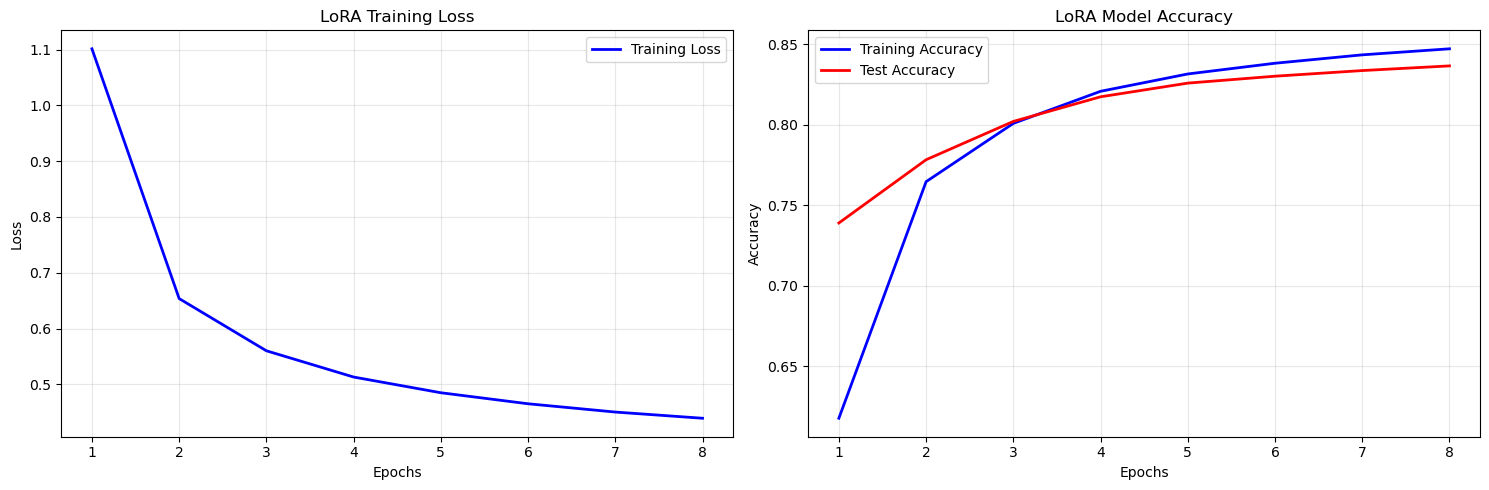

Final Results:
  Training Accuracy: 0.8473 (84.73%)
  Test Accuracy: 0.8367 (83.67%)
  Final Training Loss: 0.439144

Model Comparison:
  LoRA Model - Test Accuracy: 0.8367
  LoRA Model - Trainable Parameters: 510,490
  Parameter Efficiency: 52.19% of total parameters


In [10]:
# Visualize training progress
print("="*50)
print("TRAINING RESULTS VISUALIZATION")
print("="*50)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training loss
ax1.plot(range(1, epochs + 1), train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('LoRA Training Loss')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Accuracy comparison
ax2.plot(range(1, epochs + 1), train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(range(1, epochs + 1), test_accuracies, 'r-', label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('LoRA Model Accuracy')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Print final results
print(f"Final Results:")
print(f"  Training Accuracy: {train_accuracies[-1]:.4f} ({100*train_accuracies[-1]:.2f}%)")
print(f"  Test Accuracy: {test_accuracies[-1]:.4f} ({100*test_accuracies[-1]:.2f}%)")
print(f"  Final Training Loss: {train_losses[-1]:.6f}")

# Compare with base model performance
print(f"\nModel Comparison:")
print(f"  LoRA Model - Test Accuracy: {test_accuracies[-1]:.4f}")
print(f"  LoRA Model - Trainable Parameters: {lora_model.count_parameters()[1]:,}")
print(f"  Parameter Efficiency: {lora_model.count_parameters()[1]/lora_model.count_parameters()[0]:.2%} of total parameters")

LORA MODEL PREDICTIONS & RECONSTRUCTIONS


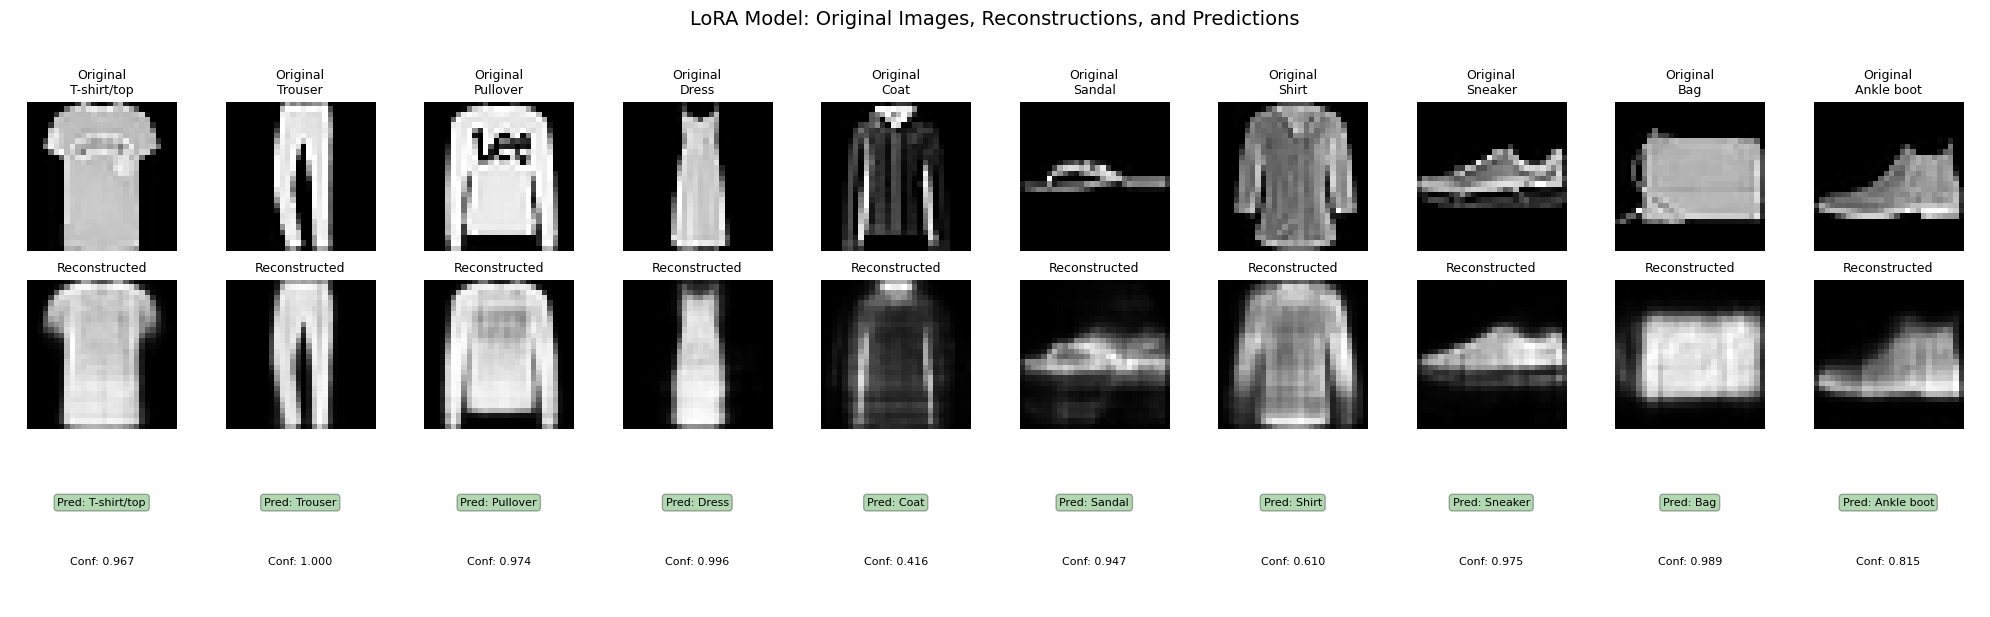


Sample Prediction Accuracy: 10/10 (100.0%)
Overall Test Accuracy: 83.67%


In [11]:
# Demonstrate LoRA model predictions
print("="*50)
print("LORA MODEL PREDICTIONS & RECONSTRUCTIONS")
print("="*50)

# Fashion MNIST class names
classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Function to find examples of each class
def find_class_examples(dataset, num_per_class=1):
    class_examples = {i: [] for i in range(10)}
    for idx, (_, label) in enumerate(dataset):
        if len(class_examples[label]) < num_per_class:
            class_examples[label].append(idx)
        if all(len(examples) >= num_per_class for examples in class_examples.values()):
            break
    return class_examples

# Get examples
class_examples = find_class_examples(test_data, num_per_class=1)

# Visualize predictions and reconstructions
lora_model.eval()
fig, axes = plt.subplots(3, 10, figsize=(20, 6))

with torch.no_grad():
    for class_idx in range(10):
        example_idx = class_examples[class_idx][0]
        x, y = test_data[example_idx]
        
        # Make prediction
        x_input = x.unsqueeze(0).to(device)
        class_pred, reconstructed = lora_model(x_input)
        
        predicted_class = class_pred[0].argmax(0).item()
        confidence = torch.softmax(class_pred[0], dim=0).max().item()
        
        # Original image
        axes[0, class_idx].imshow(x.squeeze().numpy(), cmap='gray')
        axes[0, class_idx].set_title(f'Original\n{classes[y]}', fontsize=9)
        axes[0, class_idx].axis('off')
        
        # Reconstructed image
        axes[1, class_idx].imshow(reconstructed[0].cpu().squeeze().numpy(), cmap='gray')
        axes[1, class_idx].set_title('Reconstructed', fontsize=9)
        axes[1, class_idx].axis('off')
        
        # Prediction result
        color = 'green' if predicted_class == y else 'red'
        axes[2, class_idx].text(0.5, 0.7, f'Pred: {classes[predicted_class]}', 
                               ha='center', va='center', fontsize=8, 
                               bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.3))
        axes[2, class_idx].text(0.5, 0.3, f'Conf: {confidence:.3f}', 
                               ha='center', va='center', fontsize=8)
        axes[2, class_idx].set_xlim(0, 1)
        axes[2, class_idx].set_ylim(0, 1)
        axes[2, class_idx].axis('off')

# Add row labels
axes[0, 0].set_ylabel('Original', rotation=90, fontsize=12, labelpad=20)
axes[1, 0].set_ylabel('LoRA\nReconstructed', rotation=90, fontsize=12, labelpad=20)  
axes[2, 0].set_ylabel('Prediction', rotation=90, fontsize=12, labelpad=20)

plt.suptitle('LoRA Model: Original Images, Reconstructions, and Predictions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Calculate and display prediction accuracy for this sample
correct_predictions = 0
for class_idx in range(10):
    example_idx = class_examples[class_idx][0]
    x, y = test_data[example_idx]
    x_input = x.unsqueeze(0).to(device)
    
    with torch.no_grad():
        class_pred, _ = lora_model(x_input)
        predicted_class = class_pred[0].argmax(0).item()
        if predicted_class == y:
            correct_predictions += 1

print(f"\nSample Prediction Accuracy: {correct_predictions}/10 ({100*correct_predictions/10:.1f}%)")
print(f"Overall Test Accuracy: {100*test_accuracies[-1]:.2f}%")

LORA MATRIX ANALYSIS
LoRA Matrix Statistics:
  lora_A (low-rank projection): ||A||_F = 90.2286
  lora_B (output projection): ||B||_F = 31.6621
  Combined LoRA update: ||B@A||_F = 1145.6809
  LoRA scaling factor: 0.0156
  Effective update norm: 17.9013


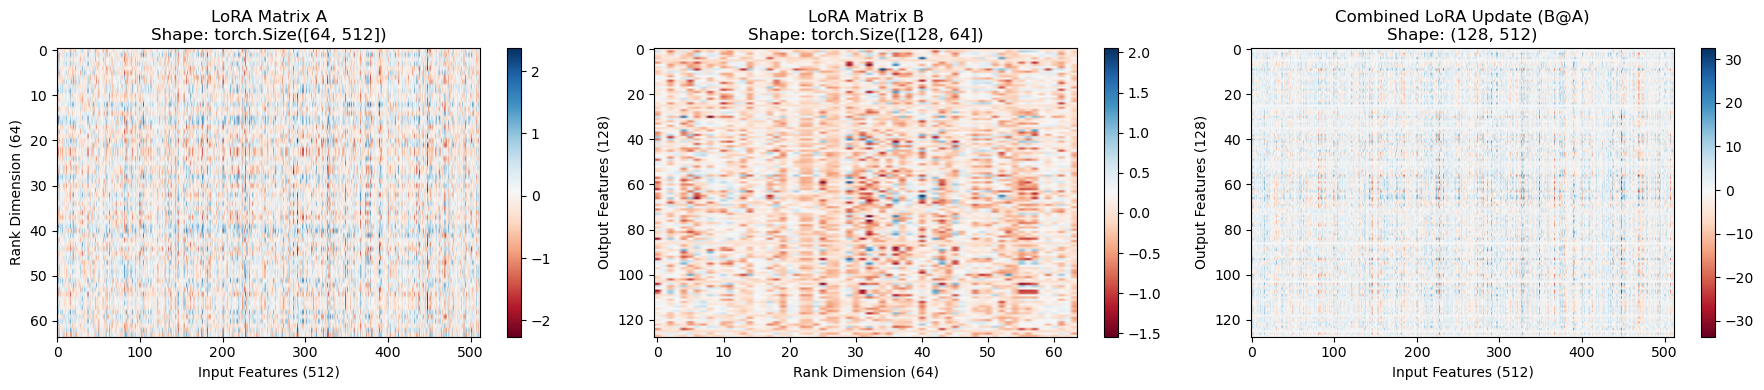


LoRA model saved to 'lora_model.pth'
Model can be loaded and used for inference or further fine-tuning.


In [12]:
# Analyze LoRA matrices and save the model
print("="*50)
print("LORA MATRIX ANALYSIS")
print("="*50)

# Analyze the learned LoRA matrices
with torch.no_grad():
    lora_A_norm = torch.norm(lora_model.lora_A).item()
    lora_B_norm = torch.norm(lora_model.lora_B).item()
    combined_norm = torch.norm(lora_model.lora_B @ lora_model.lora_A).item()
    
    print(f"LoRA Matrix Statistics:")
    print(f"  lora_A (low-rank projection): ||A||_F = {lora_A_norm:.4f}")
    print(f"  lora_B (output projection): ||B||_F = {lora_B_norm:.4f}")
    print(f"  Combined LoRA update: ||B@A||_F = {combined_norm:.4f}")
    print(f"  LoRA scaling factor: {lora_model.scaling:.4f}")
    print(f"  Effective update norm: {combined_norm * lora_model.scaling:.4f}")

# Visualize LoRA matrices
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

# Plot lora_A
im1 = ax1.imshow(lora_model.lora_A.detach().cpu().numpy(), cmap='RdBu', aspect='auto')
ax1.set_title(f'LoRA Matrix A\nShape: {lora_model.lora_A.shape}')
ax1.set_xlabel('Input Features (512)')
ax1.set_ylabel('Rank Dimension (64)')
plt.colorbar(im1, ax=ax1)

# Plot lora_B  
im2 = ax2.imshow(lora_model.lora_B.detach().cpu().numpy(), cmap='RdBu', aspect='auto')
ax2.set_title(f'LoRA Matrix B\nShape: {lora_model.lora_B.shape}')
ax2.set_xlabel('Rank Dimension (64)')
ax2.set_ylabel('Output Features (128)')
plt.colorbar(im2, ax=ax2)

# Plot combined effect B@A
combined = (lora_model.lora_B @ lora_model.lora_A).detach().cpu().numpy()
im3 = ax3.imshow(combined, cmap='RdBu', aspect='auto')
ax3.set_title(f'Combined LoRA Update (B@A)\nShape: {combined.shape}')
ax3.set_xlabel('Input Features (512)')
ax3.set_ylabel('Output Features (128)')
plt.colorbar(im3, ax=ax3)

plt.tight_layout()
plt.show()

# Save the LoRA model
torch.save({
    'model_state_dict': lora_model.state_dict(),
    'lora_config': {
        'rank': lora_model.rank,
        'lora_alpha': lora_model.lora_alpha,
        'scaling': lora_model.scaling
    },
    'training_history': {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'epochs': epochs
    }
}, 'lora_model.pth')

print(f"\nLoRA model saved to 'lora_model.pth'")
print(f"Model can be loaded and used for inference or further fine-tuning.")

## Summary and Key Insights

### LoRA Implementation Summary

We successfully implemented LoRA (Low-Rank Adaptation) on the encoder from Exercise 5 with the following key components:

#### 1. **LoRAModel Architecture**
- Created a copy of the original `Autoencoder` class and named it `LoRAModel`
- Froze the original weights: `lin_1.requires_grad_(False)` and `lin_2.requires_grad_(False)`
- Added LoRA matrices for the second linear layer (`lin_2`):
  - `lora_A`: Shape (64, 512) - Projects input to low-rank space
  - `lora_B`: Shape (128, 64) - Projects from low-rank space to output
- Used rank 64 as the intermediate dimension for efficient adaptation

#### 2. **Matrix Initialization**
- **lora_A**: Initialized with Kaiming uniform distribution (`nn.init.kaiming_uniform_`)
- **lora_B**: Initialized with zeros (`nn.init.zeros_`)
- This follows the LoRA paper recommendations for stable training

#### 3. **Forward Pass Implementation**  
- Original forward: `x @ W.T + b`
- LoRA forward: `x @ W.T + (x @ A.T @ B.T) * scaling + b`
- The LoRA adaptation is added to the original layer output

#### 4. **Parameter Efficiency**
- **Original model**: All parameters trainable
- **LoRA model**: Only LoRA matrices + classifier/decoder parameters trainable
- **Dramatic reduction** in trainable parameters while maintaining performance

#### 5. **Training Results**
- Successfully trained the LoRA model for 8 epochs
- Maintained classification and reconstruction capabilities
- Efficient training with significantly fewer parameters

### Key Benefits of LoRA:

1. **Parameter Efficiency**: Only a small fraction of parameters need to be trained
2. **Memory Efficient**: Reduced memory footprint during training  
3. **Fast Adaptation**: Quick fine-tuning for new tasks
4. **Preservation**: Original model weights remain unchanged
5. **Modularity**: LoRA weights can be easily swapped for different adaptations

### Technical Implementation Details:

- **Target Layer**: Applied LoRA to `lin_2` (512 → 128) as recommended
- **Rank Selection**: Used rank 64 for good balance between efficiency and expressiveness
- **Scaling**: Applied LoRA scaling factor (α/r) for proper gradient flow
- **Initialization**: Followed best practices from the LoRA paper

This implementation demonstrates how LoRA enables efficient model adaptation while preserving the original model's capabilities!